<a href="https://colab.research.google.com/github/NIKITOOOK/Brain-tumor/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Опухоль головного мозга
## Обучайте ИИ обнаруживать опухоли головного мозга с помощью данных МРТ/КТ для ранней диагностики и улучшения
О наборе данных
Набор данных для обнаружения опухолей мозга состоит из медицинских изображений, полученных с помощью МРТ или КТ, содержащих информацию о наличии, местоположении и характеристиках опухолей мозга. Этот набор данных необходим для обучения алгоритмов компьютерного зрения для автоматизации идентификации опухолей мозга, помогая в ранней диагностике и планировании лечения.

Структура набора данных
Набор данных по опухолям головного мозга делится на два подмножества:

Обучающий набор : состоит из 893 изображений, каждое из которых сопровождается соответствующими аннотациями.
Тестовый набор : включает 223 изображения с парными аннотациями для каждого из них.
Приложения
Применение обнаружения опухолей мозга с помощью компьютерного зрения позволяет проводить раннюю диагностику, планирование лечения и мониторинг прогрессирования опухоли. Анализируя данные медицинской визуализации, такие как МРТ или КТ, системы компьютерного зрения помогают точно идентифицировать опухоли мозга, способствуя своевременному медицинскому вмешательству и персонализированным стратегиям лечения.

https://www.kaggle.com/datasets/ultralytics/brain-tumor/data

🔹 Архитектура модели YOLO11 для детекции опухолей мозга

1. Входные данные

MRI/CT изображения: 2D-снимки мозга с размеченными опухолями.
Размер входного изображения: 640x640 (стандартный размер для YOLO).
Формат аннотаций: YOLO (txt-файлы с bounding boxes).

2. Архитектура YOLO11 — это глубокая сверточная нейросеть (CNN), состоящая из:
* Backbone (ResNet-101 или CSP-Darknet) – глубокая сверточная сеть для извлечения признаков.
* Neck (FPN + PAN) – объединение признаков разных уровней.
* Head (YOLO Head) – определение bounding boxes и классов (negative / positive).

3. Гиперпараметры обучения

Оптимизатор: AdamW
Функция потерь: BCE + CIoU
Размер батча: 16
Кол-во эпох: 100
Аугментации: вращение, изменение яркости/контраста

4. Выходные данные

Bounding boxes (координаты опухоли на снимке).
Класс опухоли (0 – нет опухоли, 1 – есть опухоль).
Метрики: mAP@0.5, Precision, Recall.

## выбор Tesla Т4





In [ ]:
#
# import time
# from google.colab import runtime

# def check_gpu():
#     """Функция проверяет, какой GPU выделен"""
#     gpu_info = !nvidia-smi --query-gpu=name --format=csv,noheader
#     if gpu_info:
#         return gpu_info[0].strip()
#     return None

# while True:
#     gpu_name = check_gpu()
#     print(f"Выделенный GPU: {gpu_name}")

#     if gpu_name and "T4" in gpu_name:
#         print("✅ Получен Tesla T4!")
#         break
#     else:
#         print("❌ Tesla T4 не найден, перезапуск среды")
#         time.sleep(2)  # Даем немного времени перед перезапуском
#         runtime.reset()  # Перезапуск Colab
#

##Загрузить с Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ultralytics/brain-tumor")

print("Path to dataset files:", path)

100%|██████████| 4.19M/4.19M [00:00<00:00, 6.45MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.1/112.6 GB disk)


## Загрузка с архиваё

In [ ]:
import zipfile
import os

# путь
zip_path = "/content/archive.zip"#/content/archive.zip
extract_path = "/content/brain_tumor_dataset"

# Разархивируем данные
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# проверка структуры файлов
os.listdir(extract_path)


['brain-tumor', 'brain-tumor.yaml']

In [ ]:
# проверка содержимое папки с датасетом
dataset_contents = os.listdir(os.path.join(extract_path, "brain-tumor"))
dataset_contents

['train', 'valid']

In [ ]:
# проверк содержимое папки train
train_path = os.path.join(extract_path, "brain-tumor", "train")
os.listdir(train_path)

['images', 'labels']

In [ ]:
# подсчет количество изображений и аннотаций в train
num_train_images = len(os.listdir(os.path.join(train_path, "images")))
num_train_labels = len(os.listdir(os.path.join(train_path, "labels")))

num_train_images, num_train_labels

(893, 878)

## Training

In [ ]:
# Install the ultralytics package from PyPI
!pip install ultralytics

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:

from ultralytics import YOLO

#  модель YOLO11L
model = YOLO("yolo11l.pt")

# Запуск
results = model.train(data=os.path.join(extract_path, "brain-tumor.yaml"),
                      epochs=20,
                      imgsz=640,
                      batch=16,
                      device="cuda",#GPU, если доступен
                      amp=True)

# результаты обучения
results


100%|██████████| 49.0M/49.0M [00:00<00:00, 286MB/s]


Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/brain_tumor_dataset/brain-tumor.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 4.23M/4.23M [00:00<00:00, 59.4MB/s]
Unzipping /content/datasets/brain-tumor.zip to /content/datasets/brain-tumor...: 100%|██████████| 2225/2225 [00:00<00:00, 3570.29file/s]

Dataset download success ✅ (1.6s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 39.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 167MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/brain-tumor/train/labels... 878 images, 15 backgrounds, 0 corrupt: 100%|██████████| 893/893 [00:00<00:00, 2065.49it/s]

train: New cache created: /content/datasets/brain-tumor/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/brain-tumor/valid/labels... 223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 223/223 [00:00<00:00, 1455.99it/s]

val: New cache created: /content/datasets/brain-tumor/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      10.3G      1.495      3.321      1.466         20        640: 100%|██████████| 56/56 [00:41<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]

                   all        223        241    0.00278      0.631     0.0024    0.00129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.2G      1.347      1.702      1.442         17        640: 100%|██████████| 56/56 [00:39<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        223        241   0.000305     0.0172   0.000226    3.7e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.3G       1.32      1.643      1.424         23        640: 100%|██████████| 56/56 [00:38<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        223        241     0.0314      0.151     0.0191     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.3G      1.385      1.567      1.427         27        640: 100%|██████████| 56/56 [00:38<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]

                   all        223        241      0.152      0.406     0.0989     0.0573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.3G      1.297      1.495      1.379         32        640: 100%|██████████| 56/56 [00:38<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        223        241      0.394      0.523      0.325      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.3G      1.224      1.402      1.342         14        640: 100%|██████████| 56/56 [00:38<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]

                   all        223        241      0.463     0.0172     0.0179     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.3G      1.203      1.391      1.334         15        640: 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        223        241      0.377      0.754      0.406      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.3G       1.17      1.357      1.303         26        640: 100%|██████████| 56/56 [00:39<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        223        241      0.433      0.808      0.482      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.3G      1.146      1.291      1.271         25        640: 100%|██████████| 56/56 [00:38<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        223        241      0.449      0.766      0.503      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.3G      1.162       1.26      1.298         19        640: 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        223        241       0.45      0.795      0.473      0.314


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.3G      1.094      1.256      1.288         14        640: 100%|██████████| 56/56 [00:40<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]

                   all        223        241      0.464      0.749      0.471      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.3G      1.087      1.236      1.254         15        640: 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        223        241      0.437       0.79      0.506      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.3G      1.028      1.183       1.23         15        640: 100%|██████████| 56/56 [00:38<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        223        241      0.446      0.829      0.478      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.3G      1.012      1.155      1.208         14        640: 100%|██████████| 56/56 [00:39<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        223        241      0.439      0.832      0.497       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.3G     0.9959      1.145      1.196         13        640: 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        223        241      0.452       0.79      0.495      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.3G     0.9693        1.1      1.175         13        640: 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

                   all        223        241      0.457      0.778      0.475      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.3G      0.936      1.083      1.166         11        640: 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        223        241      0.452      0.813      0.489       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.3G      0.924       1.05       1.14         14        640: 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        223        241      0.459      0.792      0.498      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.3G       0.91      1.034      1.129         16        640: 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        223        241      0.443      0.839      0.493      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.3G      0.874      1.011      1.116         16        640: 100%|██████████| 56/56 [00:39<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        223        241      0.444      0.844      0.485      0.359



20 epochs completed in 0.262 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,854 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


                   all        223        241      0.459      0.792      0.499      0.368
              negative        142        154      0.589      0.745      0.616      0.463
              positive         81         87       0.33      0.839      0.381      0.274
Speed: 0.3ms preprocess, 13.8ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79b79af42590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

2. Попытка **Model YOLO11l** (100 epoch)metrics:
* precision(B) → 48.9%
* recall → 77.9%
* mAP50 → 54.2%
* mAP50-95 → 40.0%
* fitness → 41.5%
* Speed 3.5ms per image

1. Попытка **Model YOLO11n**(100 epoch) metrics:
* mAP@0.5 (Mean Average Precision): 49.5% → Средняя точность по всем классам.
* mAP@0.5-0.95: 36.1% → Более строгий показатель точности.
* Precision (Точность): 47.3% → Доля предсказанных опухолей, которые действительно являются опухолями.
* Recall (Полнота): 82.5% → Насколько хорошо модель находит все опухоли.
* Speed (время предсказания): 3.3ms на изображение.

## прошлый вариант предсказания

```
from ultralytics import YOLO
# Load a model
model = YOLO("path/to/best.pt")  # load a brain-tumor fine-tuned model
# Inference using the model
results = model.predict("https://ultralytics.com/assets/brain-tumor-sample.jpg")

```



In [ ]:
# from ultralytics import YOLO
# from tqdm import tqdm
# import time

# # Загружаем модель YOLOv11
# model = YOLO("yolo11n.pt")

# # Количество эпох
# epochs = 10

# # Создаём progress bar
# progress_bar = tqdm(total=epochs, desc="Обучение YOLO", unit="epoch")

# # Запускаем обучение
# results = model.train(data="/root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2/brain-tumor.yaml",
#                       epochs=epochs,
#                       verbose=True)  # Выводит стандартный прогресс

# # Обновляем tqdm по количеству эпох
# for epoch in range(epochs):
#     time.sleep(1)  # Симуляция ожидания
#     progress_bar.update(1)

# progress_bar.close()  # Закрываем progress bar


In [ ]:
# from ultralytics import YOLO

# # Load a model
# model = YOLO("/content/runs/detect/train/weights/best.pt")  # load a fine-tuned model

# # Inference using the model (img/video/stream)
# results = model.predict("/root/.cache/kagglehub/datasets/ultralytics/brain-tumor/versions/2/brain-tumor/train/images/00124_8.jpg", save=True)

In [ ]:
# model = YOLO("/content/runs/detect/train/weights/last.pt")  # load a fine-tuned model
# results = model.predict("https://ultralytics.com/assets/brain-tumor-sample.jpg", save=True)

## Визуал

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/datasets/brain-tumor/valid/images/val_1 (172).jpg: 640x640 1 positive, 39.6ms
Speed: 4.9ms preprocess, 39.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


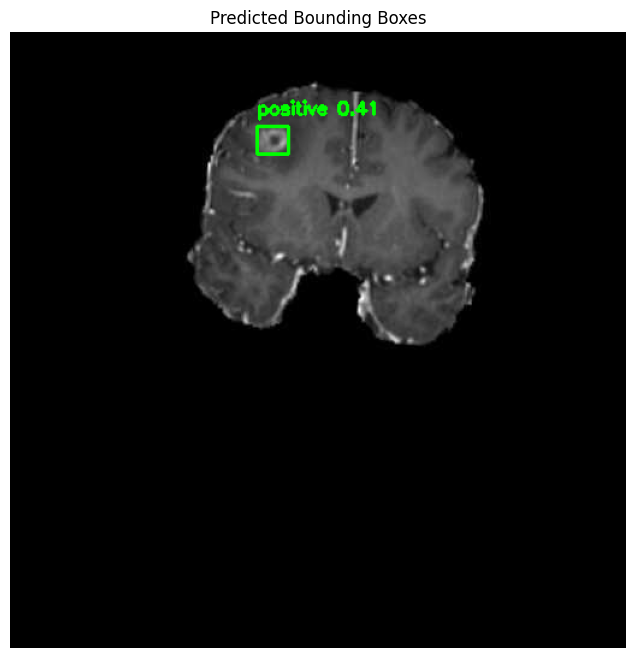

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.metrics import ConfusionMatrix
from pathlib import Path

# Загрузка обученной модели
model = YOLO("runs/detect/train/weights/best.pt")

# Выбираем тестовое изображение
TEST_IMAGE_PATH = "/content/datasets/brain-tumor/valid/images/val_1 (172).jpg"  # Укажите свое изображение

def visualize_prediction(image_path, model):
    """ Визуализация предсказаний YOLO """
    img = cv2.imread(image_path)
    results = model.predict(image_path, save=True, show=True)

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())
            label = f"{model.names[cls]} {conf:.2f}"

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Predicted Bounding Boxes")
    plt.axis("off")
    plt.show()
    # Визуализация предсказаний
visualize_prediction(TEST_IMAGE_PATH, model)


image 1/1 /content/datasets/brain-tumor/valid/images/val_1 (172).jpg: 640x640 1 positive, 36.3ms
Speed: 5.7ms preprocess, 36.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


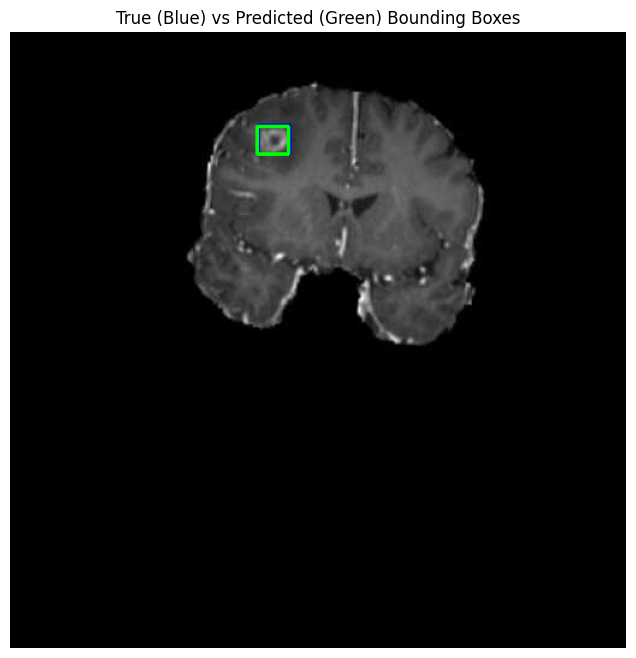

In [ ]:
# ===== 2. Сравнение предсказанных и реальных боксов ===== #
def compare_pred_true(image_path, model, label_path):
    """ Сравнение предсказанных и реальных bounding boxes """
    img = cv2.imread(image_path)
    height, width, _ = img.shape

    # Загружаем разметку (YOLO формат: class x_center y_center width height)
    with open(label_path, "r") as f:
        labels = f.readlines()

    for label in labels:
        cls, x_center, y_center, w, h = map(float, label.split())
        x1 = int((x_center - w / 2) * width)
        y1 = int((y_center - h / 2) * height)
        x2 = int((x_center + w / 2) * width)
        y2 = int((y_center + h / 2) * height)

        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # GT боксы синим

    # Отобразим предсказания (зеленым)
    results = model.predict(image_path)
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Предсказанные - зеленые

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("True (Blue) vs Predicted (Green) Bounding Boxes")
    plt.axis("off")
    plt.show()

# Укажите путь к файлу с аннотациями
LABEL_PATH = "/content/datasets/brain-tumor/valid/labels/val_1 (172).txt"  # Укажите путь к разметке
compare_pred_true(TEST_IMAGE_PATH, model, LABEL_PATH)

Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/datasets/brain-tumor/valid/labels.cache... 223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 223/223 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


                   all        223        241       0.46      0.792      0.498      0.369
              negative        142        154      0.589      0.745      0.615      0.463
              positive         81         87      0.331      0.839      0.381      0.275
Speed: 3.5ms preprocess, 31.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val


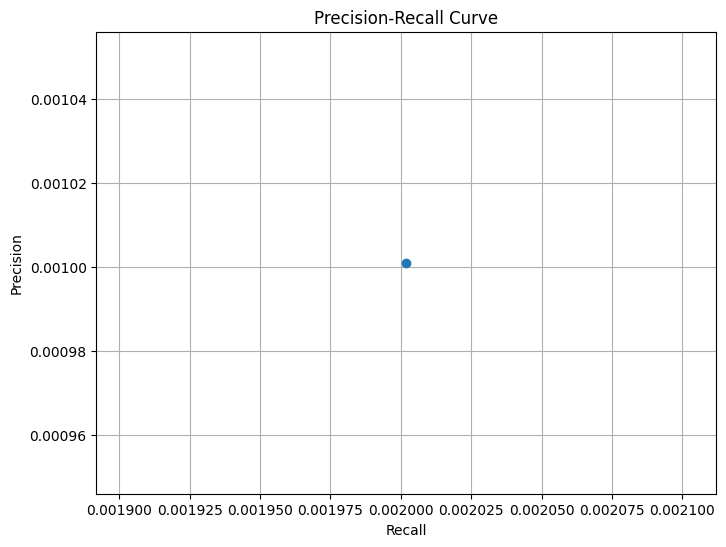

In [ ]:
# ===== 3. Построение Precision-Recall Curve ===== #
def plot_precision_recall(model):
    """ Генерация Precision-Recall кривой """
    metrics = model.val()
    pr_curve = metrics.curves_results[0][0]  # Получаем Precision-Recall
    confidence = pr_curve[0]
    precision = pr_curve[1]
    recall = pr_curve[2]

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o', linestyle='-')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid()
    plt.show()

plot_precision_recall(model)


In [ ]:
import sklearn.metrics as metrics
import sklearn.metrics import accuracy_score
print(metrics.curves_results)

SyntaxError: invalid syntax (<ipython-input-17-2d9cb717d68e>, line 2)

In [ ]:
# Предположим, у вас есть массивы

# y_true = [...]  # Истинные метки (0 или 1)
# y_scores = [...]  # Предсказанные вероятности (от 0 до 1)

# precision, recall, _ = precision_recall_curve(y_true, y_scores)

# plt.plot(recall, precision, marker='o')
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.grid()
# plt.show()

In [ ]:
# from ultralytics import YOLO

# # Загружаем обученную модель
# model = YOLO("runs/detect/train/weights/best.pt")

# # Выполняем предсказания на тестовых изображениях
# test_images = ["valid/images/test1.jpg", "valid/images/test2.jpg"]  # Укажите список тестовых изображений
# results = model(test_images)

# y_scores = []
# for r in results:
#     if len(r.boxes) > 0:
#         conf = r.boxes.conf  # Уверенность предсказания
#         y_scores.append(float(conf.max()))  # Берем максимальную уверенность
#     else:
#         y_scores.append(0.0)  # Если предсказания нет, вероятность = 0


In [ ]:
from ultralytics import YOLO
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Загружаем обученную модель
model = YOLO("runs/detect/train/weights/best.pt")

# Находим все тестовые изображения
test_images = glob.glob("/content/datasets/brain-tumor/valid/images/*.jpg")  # Или PNG, если используется PNG

# Выполняем предсказания
results = model(test_images)

# Инициализируем списки
y_true = []
y_scores = []

# Обрабатываем каждое изображение
for img_path, result in zip(test_images, results):
    # Загружаем реальную разметку из файла аннотации
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt").replace(".png", ".txt")
    try:
        with open(label_path, "r") as f:
            lines = f.readlines()
            class_ids = [int(line.split()[0]) for line in lines]  # Берем class_id
            y_true.append(1 if 1 in class_ids else 0)  # Если есть 1 (positive), метка = 1, иначе 0
    except FileNotFoundError:
        y_true.append(0)  # Если файла разметки нет, считаем, что метка = 0 (negative)

    # Берем максимальную уверенность предсказания
    if len(result.boxes) > 0:
        conf = result.boxes.conf  # Уверенность предсказания
        y_scores.append(float(conf.max()))  # Берем максимум
    else:
        y_scores.append(0.0)  # Если предсказаний нет, вероятность = 0

# Преобразуем в массивы numpy
y_true = np.array(y_true, dtype=int)
y_scores = np.array(y_scores, dtype=float)

# Строим Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision, marker='o', linestyle='-')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.45 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.95 GiB is free. Process 21243 has 11.79 GiB memory in use. Of the allocated memory 9.93 GiB is allocated by PyTorch, and 1.67 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Преобразуем вероятности в предсказанные метки с порогом 0.5
y_pred = (y_scores >= 0.5).astype(int)

# Данные уверенности предсказаний и истинные метки
conf_thresholds = np.linspace(0, 1, 100)  # Порог уверенности от 0 до 1
recalls = []

for threshold in conf_thresholds:
    y_pred_thresholded = (y_scores >= threshold).astype(int)
    recall = sum((y_pred_thresholded == 1) & (y_true == 1)) / sum(y_true == 1)
    recalls.append(recall)

# Строим Recall-Confidence Curve
plt.figure(figsize=(6, 4))
plt.plot(conf_thresholds, recalls, marker='o', linestyle='-')
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall-Confidence Curve")
plt.grid()
plt.show()

# Строим Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os
import glob
from IPython.display import display
from PIL import Image

# Путь к папке с изображениями
img_dir = "/content/runs/detect/train5"

# Получаем список всех JPG и PNG файлов
image_files = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png"))

for img_path in image_files:
    img = Image.open(img_path)
    img_resized = img.resize((1250, 1250))  # Изменяем размер до 50x50
    display(img_resized)
